In [39]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import altair as alt
import igraph
alt.renderers.enable('mimetype')
pm.__version__

'5.0.2'

In [3]:
tools = pd.read_csv("../../../datasets/Kline2.csv")
tools

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


In [4]:
island_distances = pd.read_csv("../../../datasets/island_matrix.csv")
island_distances = island_distances.set_index(island_distances.columns.values)
island_distances

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


In [5]:
society_idx, societies = pd.factorize(tools['culture'])

Note on covariance matrix: parameterization is opposite in rethinking vs. pymc. 

In rethinking: 

$$k_{i, j}=\eta^2 \exp \left(-\rho^2 d_{i, j}^2\right)$$

whereas in pyMC, the [ExpQuad kernel](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.cov.ExpQuad.html) is:

$$k\left(x, x^{\prime}\right)=\exp \left[-\frac{\left(x-x^{\prime}\right)^2}{2 \ell^2}\right]$$

We could define our own kernel to match rethinking, but it's probably easier to do a bit of algebra to get the link between $\rho^2$ and $l^2$ (or its inverse, as kernel API allows passing both) while $\eta^2$ is something we can multiply separately.

$$ \rho^2 = \frac{1}{2 \ell^2}$$
$$ \ell^2 = \frac{1}{2 \rho^2}$$
$$ (\ell^2)^{-1} = {2 \rho^2}$$


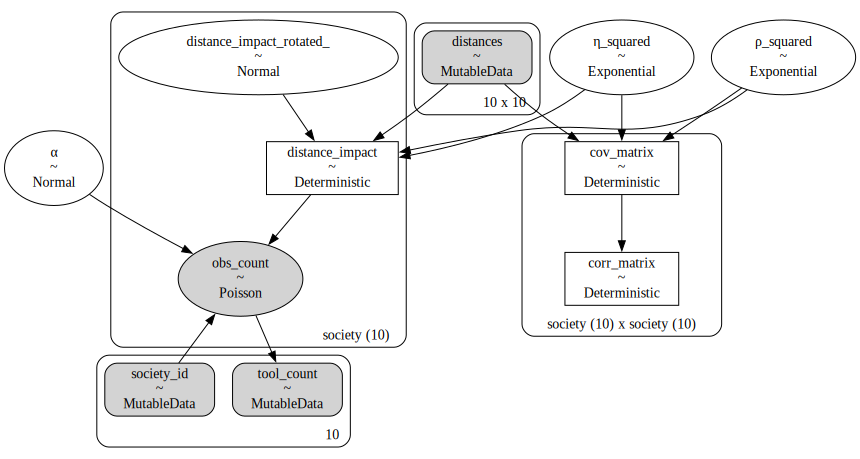

In [113]:
coords = {
    'society': societies
}


with pm.Model(coords=coords) as tools_model:

    #data
    soc_idx = pm.MutableData("society_id", society_idx, coords='society')
    count = pm.MutableData("tool_count", tools['total_tools'], coords='society')
    distances = pm.MutableData("distances", island_distances)


    #baseline
    α = pm.Normal("α", 3, 0.5)
    η = pm.Exponential("η_squared", 2)
    ρ = pm.Exponential("ρ_squared", 0.5)
    ls = 1 / (2 * ρ)

    cov_func = η * pm.gp.cov.ExpQuad(input_dim=10, ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the distances
    S = gp.prior("distance_impact", X=distances, dims='society')
    #recreate the correlation matrix and store as deterministic variable    
    cov_matrix = pm.Deterministic(
        "cov_matrix", 
        η * pm.math.exp(-(distances ** 2) / ( 2 * ls)), 
        dims=['society', 'society']
    )
    stds = pm.math.sqrt(pm.math.extract_diag(cov_matrix))
    corr_matrix = (stds ** -1) * cov_matrix * (stds ** -1)
    pm.Deterministic("corr_matrix", corr_matrix, dims=['society', 'society'])

    λ = pm.math.exp(α + S[soc_idx])

    pm.Poisson('obs_count', mu=λ, observed=count, dims='society')

pm.model_to_graphviz(tools_model)

In [114]:
with tools_model:
    tools_trace = sampling_jax.sample_blackjax_nuts(draws=4000)    
    #tools_trace = pm.sample()

Compiling...
Compilation time =  0:00:02.055945
Sampling...
Sampling time =  0:00:05.573725
Transforming variables...
Transformation time =  0:00:02.473914


In [109]:
az.summary(tools_trace, var_names=['~distance_impact_rotated_', '~cov_matrix', '~corr_matrix'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,3.477,0.231,3.110,3.919,0.027,0.020,75.0,99.0,1.05
η_squared,0.359,0.230,0.074,0.770,0.039,0.028,40.0,87.0,1.07
ρ_squared,1.157,1.719,0.030,4.353,0.117,0.083,26.0,14.0,1.11
distance_impact[Malekula],-0.661,0.283,-1.186,-0.149,0.016,0.011,288.0,638.0,1.02
distance_impact[Tikopia],-0.416,0.297,-0.950,0.107,0.031,0.025,94.0,188.0,1.04
distance_impact[Santa Cruz],-0.350,0.310,-0.963,0.161,0.041,0.036,62.0,124.0,1.05
distance_impact[Yap],0.239,0.270,-0.281,0.706,0.030,0.021,79.0,171.0,1.04
distance_impact[Lau Fiji],0.017,0.265,-0.449,0.509,0.023,0.016,126.0,623.0,1.03
distance_impact[Trobriand],-0.455,0.281,-0.948,0.079,0.032,0.027,79.0,159.0,1.04
distance_impact[Chuuk],0.173,0.263,-0.348,0.614,0.019,0.014,181.0,364.0,1.02


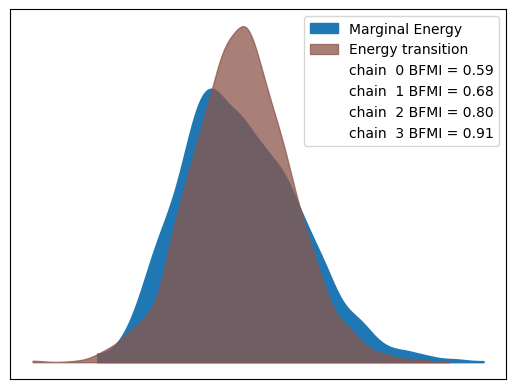

In [110]:
az.plot_energy(tools_trace)
plt.show()

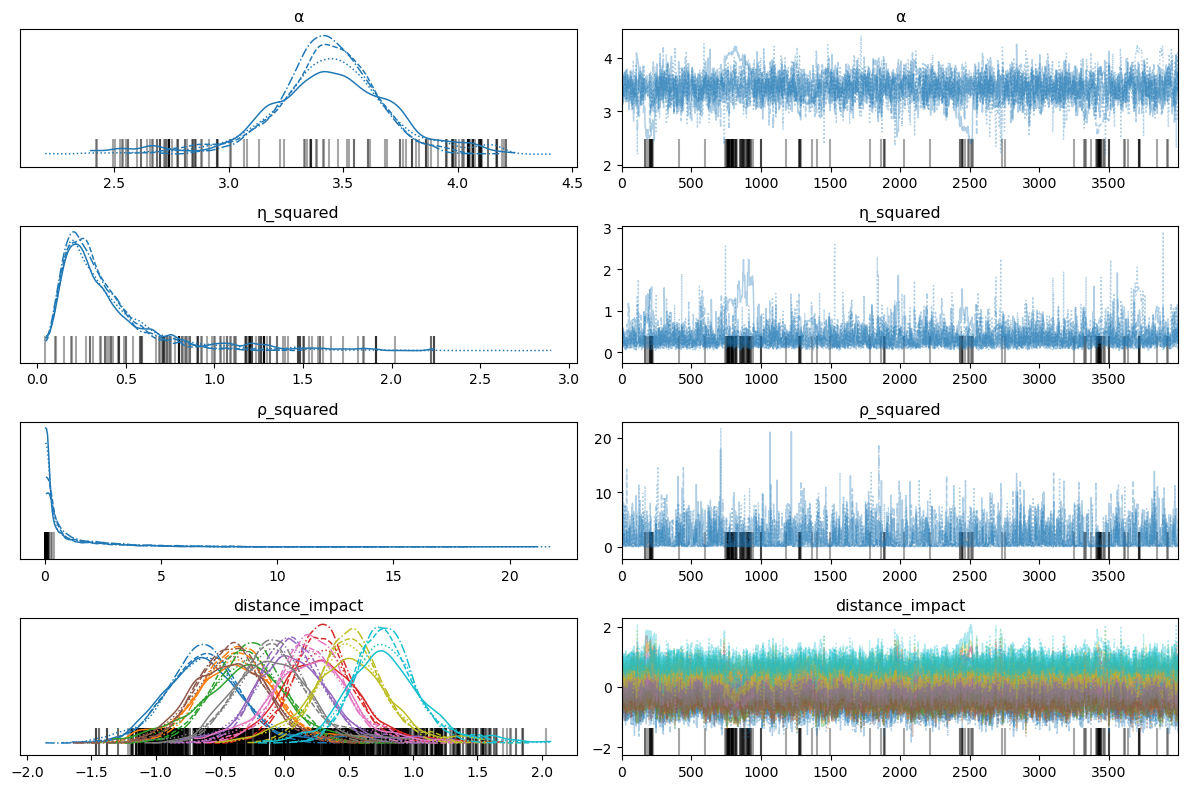

In [115]:
az.plot_trace(tools_trace, var_names=['~distance_impact_rotated_', '~cov_matrix', '~corr_matrix'])
plt.tight_layout()
plt.show()

Let's visualize the correlation structure inferred by the GP. Because it was stored in the trace, we can simply pick it up and get the mean.

Then, we build the covariance matrix based on pyMC parameterization, which is 

$$
k\left(x, x^{\prime}\right)=\exp \left[-\frac{\left(x-x^{\prime}\right)^2}{2 \ell^2}\right]
$$

In [160]:
corr_matrix_df = tools_trace['posterior']['corr_matrix'].mean(dim=['chain', 'draw']).to_pandas().round(2)
corr_matrix_df

society,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
society,,,,,,,,,,
Malekula,1.00,0.81,0.73,0.05,0.47,0.27,0.12,0.16,0.30,0.02
Tikopia,0.81,1.00,0.90,0.06,0.47,0.28,0.15,0.17,0.28,0.03
Santa Cruz,0.73,0.90,1.00,0.08,0.38,0.34,0.18,0.22,0.23,0.02
Yap,0.05,0.06,0.08,1.00,0.02,0.20,0.38,0.36,0.01,0.01
Lau Fiji,0.47,0.47,0.38,0.02,1.00,0.12,0.07,0.07,0.66,0.04
Trobriand,0.27,0.28,0.34,0.20,0.12,1.00,0.32,0.62,0.07,0.01
Chuuk,0.12,0.15,0.18,0.38,0.07,0.32,1.00,0.48,0.04,0.02
Manus,0.16,0.17,0.22,0.36,0.07,0.62,0.48,1.00,0.04,0.01
Tonga,0.30,0.28,0.23,0.01,0.66,0.07,0.04,0.04,1.00,0.03


This is a good example of making sure to capture the correlations between variables. Here's what would happen if we built a covariance matrix off mean ρ and η values directly.

In [119]:
#get the η and ρ parameters
η_squared = tools_trace['posterior']['η_squared'].to_numpy().flatten()
ρ_squared = tools_trace['posterior']['ρ_squared'].to_numpy().flatten()
l_squared = 1/ (2 * ρ_squared)

np.corrcoef(η_squared, ρ_squared)

array([[ 1.        , -0.13333555],
       [-0.13333555,  1.        ]])

In [120]:
#calculate covariance matrix directly from mean values of ρ and η
cov_matrix_no_correlation = (η_squared.mean() * np.exp(np.multiply(island_distances.values, -0.5 * 1/l_squared.mean())))

#convert to correlation matrix by obtaining standard deviations & dividing
stds = np.sqrt(np.diag(cov_matrix_no_correlation))
corr_matrix_no_correlation = (stds ** -1) * cov_matrix_no_correlation * (stds**-1)

corr_matrix_df_no_correlation = pd.DataFrame(
    corr_matrix_no_correlation, 
    columns=island_distances.columns.values, 
    index=island_distances.columns.values
).round(2)

corr_matrix_df_no_correlation

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,1.00,0.90,0.87,0.38,0.76,0.63,0.49,0.54,0.66,0.28
Tikopia,0.90,1.00,0.93,0.39,0.76,0.64,0.53,0.55,0.64,0.31
Santa Cruz,0.87,0.93,1.00,0.42,0.71,0.68,0.56,0.59,0.60,0.30
Yap,0.38,0.39,0.42,1.00,0.30,0.58,0.71,0.70,0.25,0.20
Lau Fiji,0.76,0.76,0.71,0.30,1.00,0.49,0.41,0.42,0.84,0.34
Trobriand,0.63,0.64,0.68,0.58,0.49,1.00,0.67,0.83,0.42,0.23
Chuuk,0.49,0.53,0.56,0.71,0.41,0.67,1.00,0.76,0.34,0.27
Manus,0.54,0.55,0.59,0.70,0.42,0.83,0.76,1.00,0.36,0.22
Tonga,0.66,0.64,0.60,0.25,0.84,0.42,0.34,0.36,1.00,0.32
Hawaii,0.28,0.31,0.30,0.20,0.34,0.23,0.27,0.22,0.32,1.00


Looks like it can make quite a difference in some cases!

In [124]:
corr_matrix_df_no_correlation - corr_matrix_df

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,0.00,0.09,0.14,0.33,0.29,0.36,0.37,0.38,0.36,0.26
Tikopia,0.09,0.00,0.03,0.33,0.29,0.36,0.38,0.38,0.36,0.28
Santa Cruz,0.14,0.03,0.00,0.34,0.33,0.34,0.38,0.37,0.37,0.28
Yap,0.33,0.33,0.34,0.00,0.28,0.38,0.33,0.34,0.24,0.19
Lau Fiji,0.29,0.29,0.33,0.28,0.00,0.37,0.34,0.35,0.18,0.30
Trobriand,0.36,0.36,0.34,0.38,0.37,0.00,0.35,0.21,0.35,0.22
Chuuk,0.37,0.38,0.38,0.33,0.34,0.35,0.00,0.28,0.30,0.25
Manus,0.38,0.38,0.37,0.34,0.35,0.21,0.28,0.00,0.32,0.21
Tonga,0.36,0.36,0.37,0.24,0.18,0.35,0.30,0.32,0.00,0.29
Hawaii,0.26,0.28,0.28,0.19,0.30,0.22,0.25,0.21,0.29,0.00


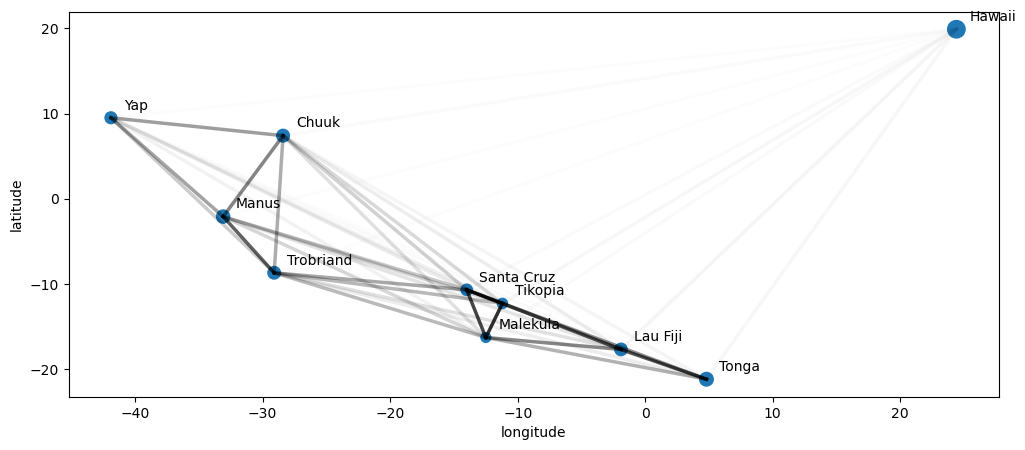

In [125]:
# adapted from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb 
fig, ax = plt.subplots(figsize=(12, 5))

# overlay lines shaded by correlation
longs = [(tools["lon2"][i], tools["lon2"][j]) for i in range(10) for j in range(i + 1, 10)]
lats = [(tools["lat"][i], tools["lat"][j]) for i in range(10) for j in range(i + 1, 10)]
correlations = [corr_matrix_df.iloc[i, j] for i in range(10) for j in range(i + 1, 10)]

for lon, lat, c in zip(longs, lats, correlations):
    ax.plot(lon, lat, "k-", alpha=c, lw=2.5)

# plot raw data and labels
ax.scatter(tools["lon2"], tools["lat"], tools['logpop'] ** 2)

for label, lat, lon in tools[['culture', 'lat', 'lon2']].itertuples(index=False):
    ax.text(lon + 1, lat + 1, label)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
plt.show()

## Tools model stratified by population size

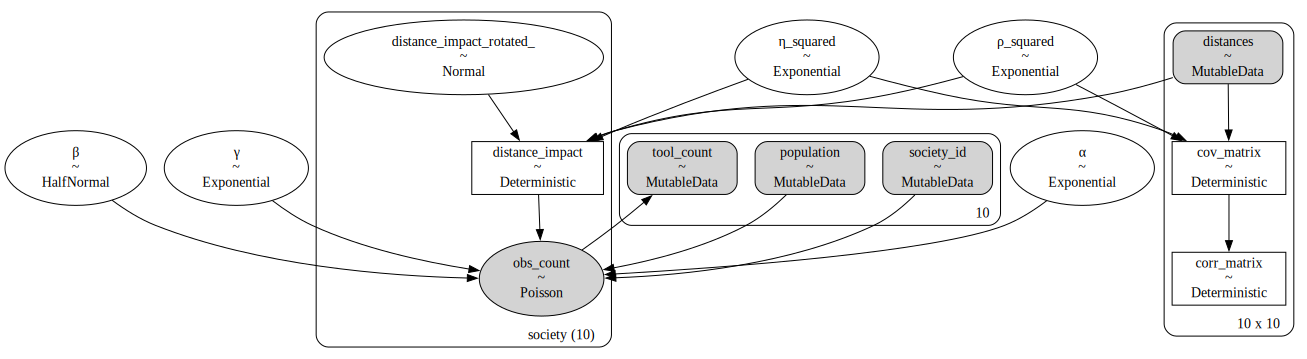

In [164]:
coords = {
    'society': societies
}

with pm.Model(coords=coords) as pop_model:

    #data
    soc_idx = pm.MutableData("society_id", society_idx, coords='society')
    count = pm.MutableData("tool_count", tools['total_tools'], coords='society')
    distances = pm.MutableData("distances", island_distances)
    population = pm.MutableData("population", tools['population'])


    #baseline
    α = pm.Exponential("α", 1)
    β = pm.HalfNormal("β", 0.5) #need a tighter prior for this one 
    γ = pm.Exponential("γ", 1)
    η = pm.Exponential("η_squared", 2)
    ρ = pm.Exponential("ρ_squared", 0.5)
    ls = 1 / (2 * ρ)

    cov_func = η * pm.gp.cov.ExpQuad(input_dim=10, ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the distances
    S = gp.prior("distance_impact", X=distances, dims='society')
    #recreate the correlation matrix and store as deterministic variable    
    cov_matrix = pm.Deterministic(
        "cov_matrix", 
        η * pm.math.exp(-(distances ** 2) / ( 2 * ls)), 
        #dims=['society', 'society']
    )
    stds = pm.math.sqrt(pm.math.extract_diag(cov_matrix))
    corr_matrix = (stds ** -1) * cov_matrix * (stds ** -1)
    pm.Deterministic(
        "corr_matrix", 
        corr_matrix, 
    
    #     dims=['society', 'society']
    )

    λ = pm.math.exp(S[soc_idx]) * (α * (population ** β)) / γ

    pm.Poisson('obs_count', mu=λ, observed=count, dims='society')

pm.model_to_graphviz(pop_model)

In [165]:
with pop_model:
    pop_trace = sampling_jax.sample_blackjax_nuts(draws=4000)
    #pop_trace = pm.sample()

Compiling...
Compilation time =  0:00:02.272895
Sampling...
Sampling time =  0:00:06.031458
Transforming variables...
Transformation time =  0:00:12.498716


In [154]:
az.summary(pop_trace, var_names=['~distance_impact_rotated_', '~cov_matrix', '~corr_matrix'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.394,1.038,0.018,3.247,0.009,0.006,9552.0,7367.0,1.0
β,0.278,0.082,0.122,0.438,0.001,0.001,5958.0,5303.0,1.0
γ,0.608,0.564,0.008,1.615,0.006,0.004,7540.0,6534.0,1.0
η_squared,0.178,0.188,0.006,0.470,0.003,0.002,4385.0,7369.0,1.0
ρ_squared,1.618,1.896,0.020,5.076,0.024,0.017,2808.0,5048.0,1.0
distance_impact[Malekula],-0.158,0.297,-0.719,0.397,0.003,0.002,8129.0,8971.0,1.0
distance_impact[Tikopia],0.027,0.285,-0.520,0.550,0.003,0.002,7318.0,8013.0,1.0
distance_impact[Santa Cruz],-0.043,0.263,-0.532,0.427,0.003,0.002,8889.0,7978.0,1.0
distance_impact[Yap],0.364,0.250,-0.079,0.818,0.003,0.002,8493.0,9548.0,1.0
distance_impact[Lau Fiji],0.071,0.245,-0.382,0.504,0.003,0.002,9553.0,8665.0,1.0


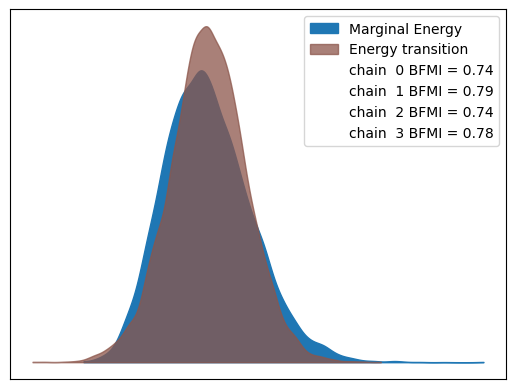

In [155]:
az.plot_energy(pop_trace)
plt.show()

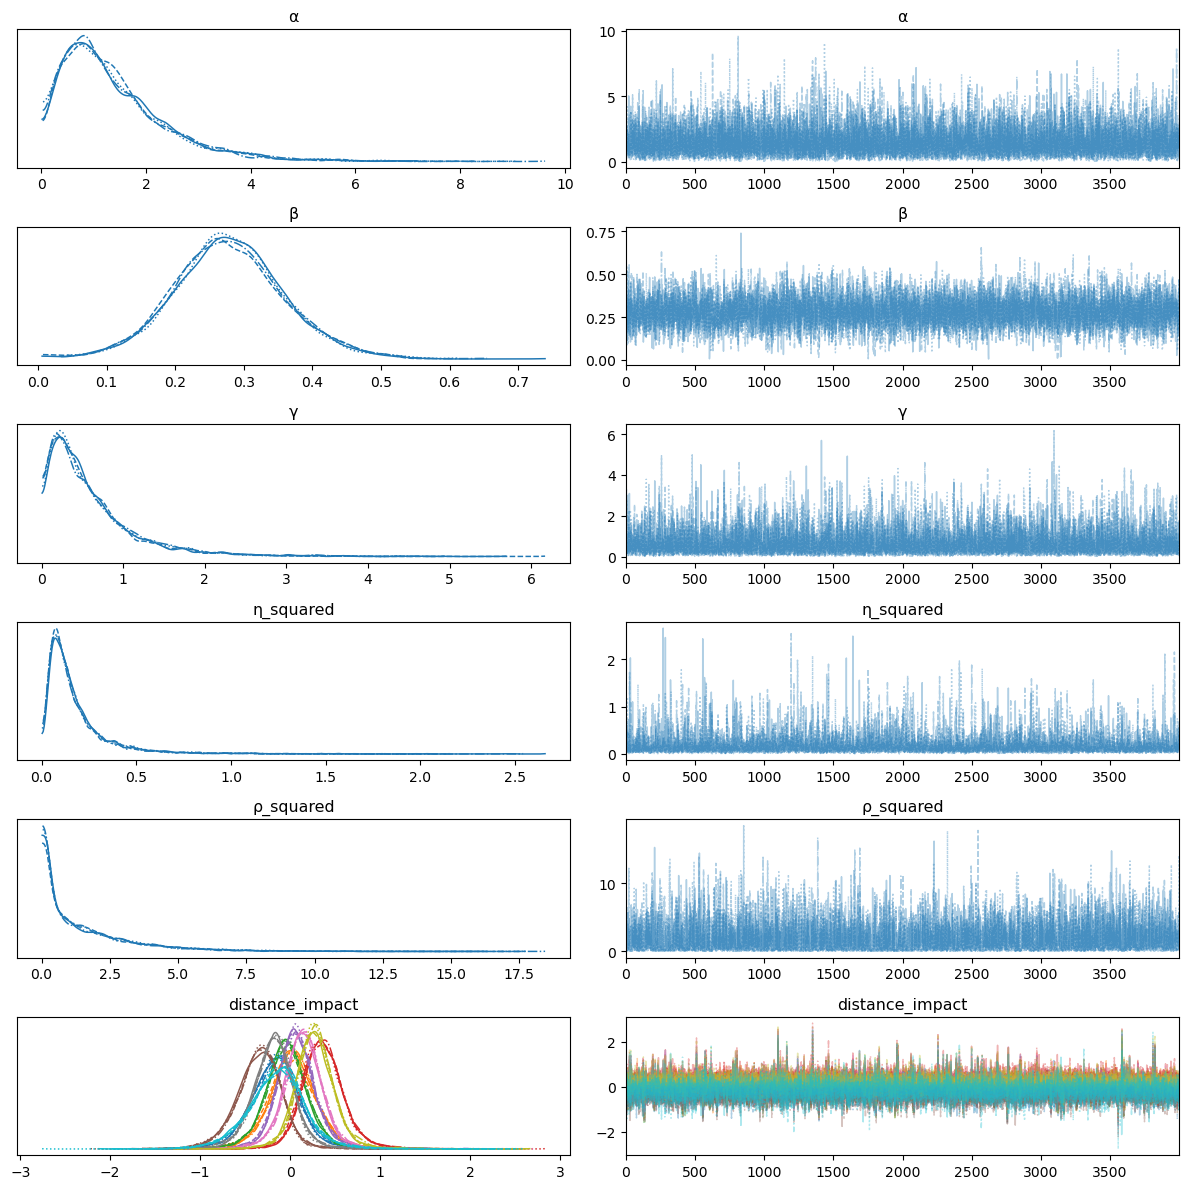

In [157]:
az.plot_trace(pop_trace, var_names=['~distance_impact_rotated_', '~cov_matrix', '~corr_matrix'])
plt.tight_layout()
plt.show()

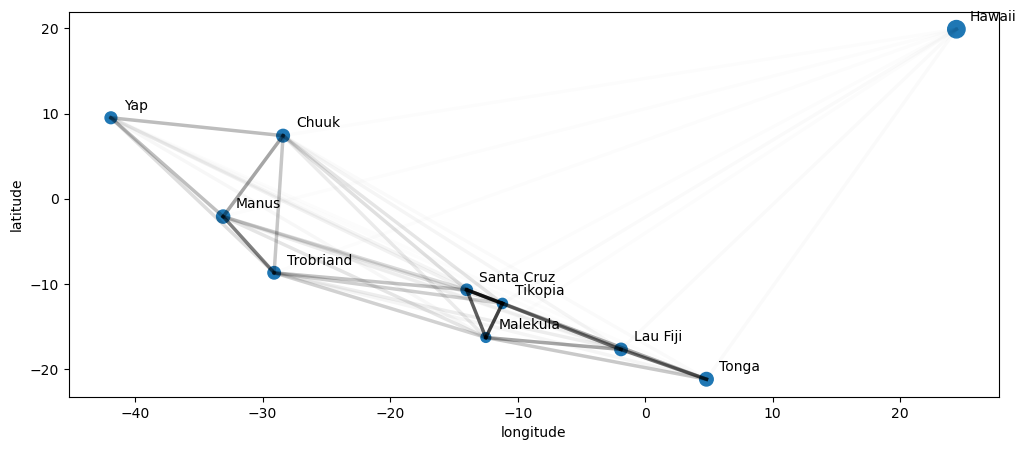

In [159]:
corr_matrix_df_pop = pop_trace['posterior']['corr_matrix'].mean(dim=['chain', 'draw']).to_pandas().round(2)
corr_matrix_df_pop

# adapted from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb 
fig, ax = plt.subplots(figsize=(12, 5))

# overlay lines shaded by correlation
longs = [(tools["lon2"][i], tools["lon2"][j]) for i in range(10) for j in range(i + 1, 10)]
lats = [(tools["lat"][i], tools["lat"][j]) for i in range(10) for j in range(i + 1, 10)]
correlations = [corr_matrix_df_pop.iloc[i, j] for i in range(10) for j in range(i + 1, 10)]

for lon, lat, c in zip(longs, lats, correlations):
    ax.plot(lon, lat, "k-", alpha=c, lw=2.5)

# plot raw data and labels
ax.scatter(tools["lon2"], tools["lat"], tools['logpop'] ** 2)

for label, lat, lon in tools[['culture', 'lat', 'lon2']].itertuples(index=False):
    ax.text(lon + 1, lat + 1, label)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
plt.show()

In [161]:
corr_matrix_df - corr_matrix_df_pop

society,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
society,,,,,,,,,,
Malekula,0.00,0.07,0.10,0.02,0.12,0.09,0.04,0.06,0.09,0.01
Tikopia,0.07,0.00,0.03,0.02,0.12,0.09,0.05,0.06,0.09,0.01
Santa Cruz,0.10,0.03,0.00,0.03,0.11,0.11,0.06,0.08,0.08,0.01
Yap,0.02,0.02,0.03,0.00,0.01,0.07,0.12,0.11,0.00,0.01
Lau Fiji,0.12,0.12,0.11,0.01,0.00,0.05,0.03,0.03,0.11,0.02
Trobriand,0.09,0.09,0.11,0.07,0.05,0.00,0.10,0.12,0.03,0.00
Chuuk,0.04,0.05,0.06,0.12,0.03,0.10,0.00,0.13,0.02,0.01
Manus,0.06,0.06,0.08,0.11,0.03,0.12,0.13,0.00,0.01,0.00
Tonga,0.09,0.09,0.08,0.00,0.11,0.03,0.02,0.01,0.00,0.01


In [166]:
with pop_model:
    ppc = pm.sample_posterior_predictive(pop_trace)

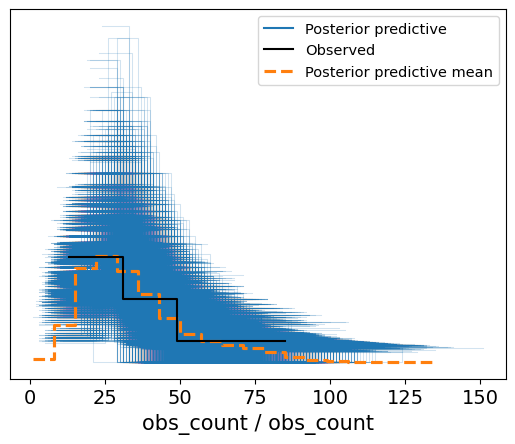

In [168]:
az.plot_ppc(ppc)
plt.show()